<a href="https://colab.research.google.com/github/Leo-Muo/Unsupervised-Learning-Algorithm-/blob/main/AI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import multivariate_normal

In [ ]:
from google.colab import files
uploaded = files.upload()
crop = pd.read_csv("Crop_recommendation.csv")
crop.drop('label', inplace=True, axis=1)
crop_data= np.array(crop)

Saving Crop_recommendation.csv to Crop_recommendation (1).csv


# implemented silhouette

In [ ]:
def inertia(list_data, centroids):
    sum=0
    for i in range(len(list_data)):
        for j in list_data[i]:
            sum+= distance(j, centroids[i])
    return sum 

In [ ]:
def distance(a:list, b:list):
    sum = 0
    for i in range(len(a)):
        sum += (a[i]-b[i])*(a[i]-b[i])
    return sum**0.5 

In [ ]:
def first_centroids_assignation(points:list, nb_clusters:int):
    return [points[i] for i in range(nb_clusters)]

In [ ]:
def mean(cluster:list):
    nb_dimension = len(cluster[0])
    number_of_point = len(cluster)
    center=[]

    # for each dimension
    for dim in range(nb_dimension):
        sum = 0
        # for each point
        for point in cluster:
            sum += point[dim]

        center.append(sum / number_of_point)
    return center

In [ ]:
def silhouette(dataset):
    final = []
    leng = len(dataset)
    sil = []

    #for each cluster 
    for cluster in range(leng):
        sol = []
        lon = len(dataset[cluster])
        other_cluster=[]
        
        for num in range(leng):
            if(num != cluster):
                other_cluster.append(dataset[num])
        
        silhouette_coef = 0
        for point in dataset[cluster]:
            a, b = 0, -1
            # we calculate a 
            for i in dataset[cluster]:
                a += distance(point, i)
            if(lon != 1):
                a /= lon-1

            # then we calculate b
            for cl in other_cluster:
                total = 0
                for other_point in cl:
                    total += distance(point, other_point)
                b = min(b, total/len(cl)) if b != -1 else total/len(cl)
            
            if(max(a,b) !=0):
                sol.append((b-a)/max(b,a))    
                silhouette_coef += (b-a)/max(b,a)
            else:
                silhouette_coef+=b-a
        if(lon !=1):
            sil.append(sol)            
            final.append(silhouette_coef/(lon-1))
        else:
            final.append(silhouette_coef)
    return(final,sil)

In [ ]:
def silhouette_graph(values_list,final):
    color_array = ["red", "b", "g", "y","m","c"]
    silhouette_avg = 0
    for i in final:
        silhouette_avg+=i
    silhouette_avg/=len(final)    
    ax = plt.subplot()
    ax.set_xlim([-0.1, 1])
    prog =0
    g_len=0
    for i in values_list:  
        for y in i:
            g_len+=1
    ax.set_ylim([0,g_len + (len(values_list)+1)*10])    
    y_lower = 10
    for cluster in values_list:
        cluster.sort()
        y_upper = y_lower + len(cluster)    
        color = color_array[prog]
        ax.fill_betweenx(np.arange(y_lower,y_upper), 0, cluster, facecolor = color, edgecolor = color, alpha = 0.7)
        ax.text(-0.05, y_lower +0.5*len(cluster), str(prog))
        y_lower = y_upper +10
        prog+=1
    ax.axvline(x=silhouette_avg, color="k", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [ ]:
def inertia_graph(max_cluster,cropdata):
  n_clusters=np.arange(3, max_cluster+1)
  inrt=[]
  for n in n_clusters:
      model = GMM(n,8)
      model.fit(cropdata)
      prer = model.predict(cropdata)
      fr = pd.DataFrame(cropdata)
      fr['cluster'] = prer
      fr.columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'cluster']
      result = cluster_valuesGMM(fr)
      centroids = [mean(result[i]) for i in range(n)]
      inrt.append(inertia(result, centroids))
    
  plt.figure(figsize=(8,8))
  plt.plot(n_clusters, inrt, 'bo-', color='black')
  plt.xlabel('k')
  plt.ylabel('inertia Score')
  plt.show()

# My implementation of GMM

In [ ]:
class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(),bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

# Implementations

In [ ]:
def cluster_scatter(dataset,cltr):
  color=['blue','green','cyan', 'black', 'red','yellow','pink']
  for k in range(0,cltr):
      dta = dataset[dataset["cluster"]==k]
      plt.scatter(dta['ph'],dta['rainfall'],c=color[k])
  plt.show()

In [ ]:
def cluster_valuesGMM(dataset):
  clusters_size = len(np.array(dataset.cluster.unique()))
  data=[]
  for k in range(0,clusters_size):
      temp_data = dataset[dataset["cluster"]==k]
      temp_data = np.array(temp_data)
      data.append(temp_data)
  return np.array(data)

In [ ]:
crop_data.shape

(2200, 7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


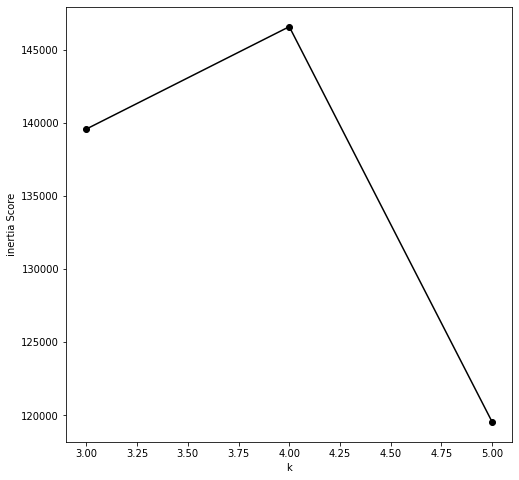

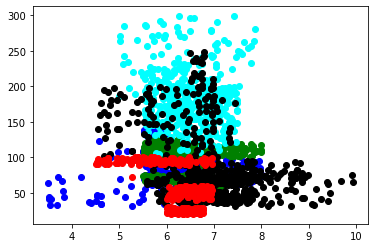

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


inertia:  142369.19246771449
Average of my_list is 0.15852526564001912

Silhouette coeficients :
	cluster 0 : 0.12336656002066881
	cluster 1 : -0.03543796456688319
	cluster 2 : 0.3761504248438377
	cluster 3 : 0.07784199587372923
	cluster 4 : 0.250705312028743


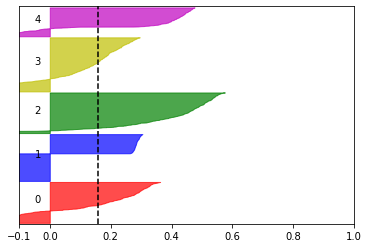

In [ ]:
cltr = 5
inertia_graph(cltr,crop_data)

model = GMM(cltr,8)
model.fit(crop_data)
cluster_column = model.predict(crop_data)

fr = pd.DataFrame(crop_data)
fr.columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
fr['cluster'] = cluster_column

cluster_scatter(fr,cltr)

result = cluster_valuesGMM(fr)

centroids = [mean(result[i]) for i in range(cltr)]
ine = inertia(result, centroids)
print("inertia: ", ine)


sl,f = silhouette(result)

print(f"Average of my_list is {np.mean(sl)}\n")

print("Silhouette coeficients :")
for index,value in enumerate(sl):
        print(f'\tcluster {index} : {value}')

silhouette_graph(f,sl)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


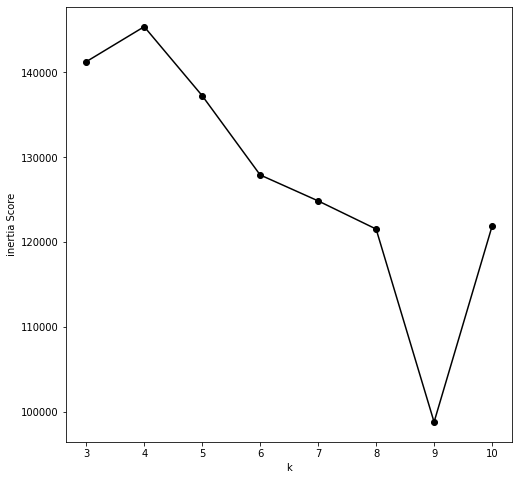

In [ ]:
n_clusters=np.arange(3, 11)
inrt=[]
for n in n_clusters:
    model = GMM(n,8)
    model.fit(crop_data)
    prer = model.predict(crop_data)
    fr = pd.DataFrame(crop_data)
    fr['cluster'] = prer
    fr.columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'cluster']
    result = cluster_valuesGMM(fr)
    centroids = [mean(result[i]) for i in range(n)]
    inrt.append(inertia(result, centroids))
    
plt.figure(figsize=(8,8))
plt.plot(n_clusters, inrt, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('inertia Score')
plt.show()